# CTM MILP Model Running Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *
from ctmmodels.delaythroughput import DelayThroughputAltPhasing as Model

In [2]:
IMAGE_PATH = 'graphs/'

**Notes on the models and parameters being used:**

* 2 separate formulations were made: 1 dealing with individual movements in the intersection, and another dealing with phases in the stoplight. The latter has 33% less binary variables, and thus performed better in basic tests.

* Saturation flow rate will be set to 600 vph instead of the 450 vph in the parent paper; this is so as to test both under and over saturated conditions.

* Traffic will be distributed evenly between the 3 possible turns (left, through, and right). This is based on previous tests where left was getting essentially 0 green time.

* Time range will be set to 60 seconds, or 30 time steps at 2 seconds per time step. Preliminary experiments show that 50 is the optimal cycle time for both delay and throughput (at demands ranging from 450 to 900 vph). *However*, previous tests on this model showed that no time was allotted to left turns when the cycle time was too small.

In [3]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 1.0/3.0,
    'r_through': 1.0/3.0,
    'r_right': 1.0/3.0,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20
}

# Varying parameters: demand, use_flow_weight, flow_weight, alpha

In [4]:
def run_model(demand, use=False, flow_weight=0.0, alpha=1.0, log_output=True):
    model = Model(
        demand=demand,
        use_flow_weight=use,
        flow_weight=flow_weight,
        alpha=alpha,
        **parameters
    )
    model.generate()
    runtime = model.solve(log_output=log_output)
    dfx, dfy, dfg = model.return_solution()
    dfparams = model.return_parameters()
    obj_values = model.return_objective_value()
    return dfx, dfy, dfg, dfparams, obj_values, runtime

In [7]:
dfx, dfy, dfg, dfparams, obj_values, runtime = run_model(demand=600, alpha=0.5, use=True, flow_weight=0.5)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 1940 rows and 292 columns.
MIP Presolve modified 752 coefficients.
Aggregator did 128 substitutions.
Reduced MIP has 3482 rows, 1860 columns, and 12232 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.67 ticks)
Found incumbent of value 1142.470610 after 0.04 sec. (26.16 ticks)
Probing fixed 0 vars, tightened 142 bounds.
Probing time = 0.00 sec. (0.61 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2790 rows, 1668 columns, and 10524 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.55 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 2790 rows, 1668 columns, and 10524 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.


In [8]:
obj_values

(1287.1040787623067, 44.306610407876214)

## Intersection Cell Network

![title](img/4leg-intersection.png)

## Setting the path of cells to check

In [5]:
_approach = 0

_approach_terms = [
    'Left',
    'Through',
    'Right'
]

_cell_path = [
    (CELL_SOURCE,0,_approach),
    (CELL_NORMAL,0,_approach),
    (CELL_NORMAL,1,_approach),
    (CELL_NORMAL,2,_approach),
    (CELL_MOVEMENT,THROUGH_TURN,_approach),
    S_mapping((CELL_MOVEMENT,THROUGH_TURN,_approach))[0]
]

def movement_paths(approach):
    return [
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,LEFT_TURN,approach),
            S_mapping((CELL_MOVEMENT,LEFT_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,THROUGH_TURN,approach),
            S_mapping((CELL_MOVEMENT,THROUGH_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,RIGHT_TURN,approach),
            S_mapping((CELL_MOVEMENT,RIGHT_TURN,approach))[0]
        ]
    ]

## Comparing cell volumes

In [6]:
def plot_volume(dfx, cell_path, title, headless=True, filename='volume.png'):
    dfx_approach = pd.concat([
        dfx[dfx.cell == c].sort_values(by='timestep')
        for c in cell_path
    ]).pivot(index='timestep', columns='cell', values='volume')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))
    
    sns.lineplot(data=dfx_approach, ax=axs[0])
    sns.lineplot(data=dfx_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Volume of cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous volume')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Volume of cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative volume')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing flows

In [7]:
def plot_flow(dfy, cell_path, title, headless=True, filename='flow.png'):
    dfy_approach = pd.concat([
        dfy[dfy.cell_from == c].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
        for c in cell_path
    ]).reset_index().pivot(index='timestep', columns='cell_from', values='flow')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))

    sns.lineplot(data=dfy_approach, ax=axs[0])
    sns.lineplot(data=dfy_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Flow from cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous flow')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Flow from cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative flow')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing specific green time

In [8]:
all_phases = [intToBinTuple(x) for x in range(8)]
all_phases_labels = [
    "Left, Westbound",
    "Through, Eastbound",
    "Left, Southbound",
    "Through, Southbound",
    "Left, Eastbound",
    "Through, Westbound",
    "Left, Northbound",
    "Through, Northbound",
]

def plot_greentime(dfg, title, headless=True, filename='greentime.png'):
    dfg_map = dfg.pivot(index='timestep', columns='cell', values='is_green')

    fig, axs = plt.subplots(8,1,figsize=(18,18), sharey=True)

    for ndx, t in enumerate(all_phases):
        sns.lineplot(data=dfg_map[t], ax=axs[ndx])
        axs[ndx].text(0.01,.5,all_phases_labels[ndx],
            horizontalalignment='left',
            transform=axs[ndx].transAxes,
            fontsize='large')
        axs[ndx].set_xticks(time_ticks, minor=False)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Generating graphs for each model case

In [9]:
def generate_graphs(dfx, dfy, dfg, capacity, max_flow, demand, alpha, flow_weight, folder=''):
    cell_paths = movement_paths(_approach)
    
    for ndx, cellpath in enumerate(cell_paths):
        plot_volume(dfx,
                    cellpath,
                    '''Volume in cells at {} vph and {}% delay weight ({} turn)
                    (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                        .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                    filename=folder+'volumes/{}vph_{}alpha_{}flow_volume_{}.png'
                        .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
        
        plot_flow(dfy,
                  cellpath,
                  '''Flow from cells at {} vph and {}% delay weight ({} turn)
                  (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                      .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                  filename=folder+'flows/{}vph_{}alpha_{}flow_flow_{}.png'
                      .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
    
    plot_greentime(dfg,
                   '''Green times at {} vph and {}% delay weight
                   (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                       .format(demand, alpha*100, capacity, max_flow, flow_weight),
                   filename=folder+'greentimes/{}vph_{}alpha_{}flow_greetime.png'
                       .format(demand, alpha, flow_weight))
    

## 1. Checking the effect of flow weight

### Alpha = 1, Demand = 600

In [15]:
flow_weights = [(x / 10.0) for x in range(11)]
#flow_weights = []

runtimes = []
obj_value_list = []

for f in flow_weights:
    dfx, dfy, dfg, dfparams, obj_values, runtime = run_model(demand=600, alpha=1, use=f>0.05, flow_weight=f, log_output=False)
    runtimes.append(runtime)
    obj_value_list.append(obj_values)
    #generate_graphs(dfx, dfy, dfg, dfparams.capacity[(3,0,1)], dfparams.max_flow[(3,0,1)], 450, 1, f, folder='flow_weights/')
    print("\n~~~\nDone with {}!\n~~~\n".format(f))

Solving...
Done!
Time elapsed: 8.35173296928

~~~
Done with 0.0!
~~~

Solving...
Done!
Time elapsed: 26.4537420273

~~~
Done with 0.1!
~~~

Solving...
Done!
Time elapsed: 32.5838108063

~~~
Done with 0.2!
~~~

Solving...
Done!
Time elapsed: 14.4348168373

~~~
Done with 0.3!
~~~

Solving...
Done!
Time elapsed: 12.5598320961

~~~
Done with 0.4!
~~~

Solving...
Done!
Time elapsed: 44.8786430359

~~~
Done with 0.5!
~~~

Solving...
Done!
Time elapsed: 12.0067279339

~~~
Done with 0.6!
~~~

Solving...
Done!
Time elapsed: 14.1228048801

~~~
Done with 0.7!
~~~

Solving...
Done!
Time elapsed: 52.328442812

~~~
Done with 0.8!
~~~

Solving...
Done!
Time elapsed: 35.9654290676

~~~
Done with 0.9!
~~~

Solving...
Done!
Time elapsed: 36.0814919472

~~~
Done with 1.0!
~~~



In [17]:
obj_value_list

[(1287.1040787623065, 44.30661040787621),
 (1287.1040787623067, 44.30661040787621),
 (1287.1040787623067, 44.30661040787621),
 (1287.1040683455344, 44.30661040787621),
 (1287.1040787623067, 44.30661040787621),
 (1287.103978762112, 44.30661040787621),
 (1287.1040787623067, 44.306610407876214),
 (1287.1040787623065, 44.306610407876214),
 (1287.1040650122738, 44.306610407876214),
 (1287.1040787623067, 44.306610407876214),
 (1287.1040683456213, 44.30661040787621)]

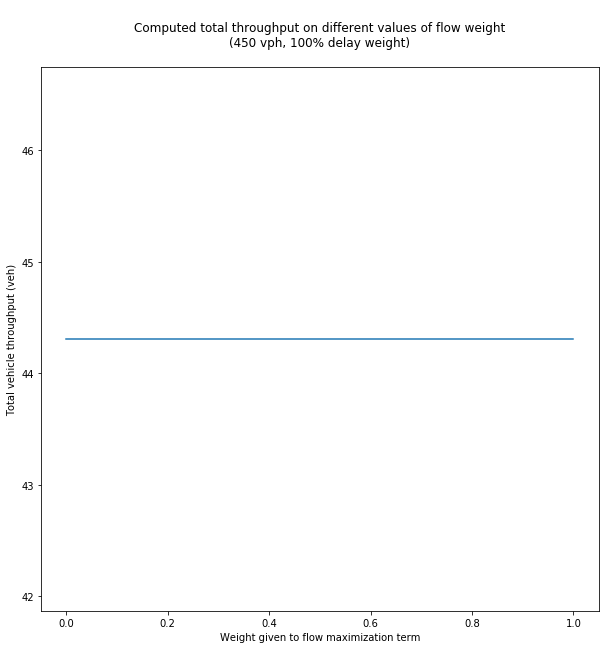

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.plot(np.arange(0,1.05,0.1), [x[1] for x in obj_value_list])
ax.set_title('''
Computed total throughput on different values of flow weight
(450 vph, 100% delay weight)
''')
ax.set_ylabel("Total vehicle throughput (veh)")
ax.set_xlabel("Weight given to flow maximization term")
fig.savefig("graphs/throughput.png")

### Alpha = 0, Demand = 600

In [21]:
flow_weights = [(x / 10.0) for x in range(11)]
#flow_weights = []

runtimes = []
obj_value_list = []

for f in flow_weights:
    dfx, dfy, dfg, dfparams, obj_values, runtime = run_model(demand=600, alpha=0, use=f>0.05, flow_weight=f)
    runtimes.append(runtime)
    obj_value_list.append(obj_values)
    generate_graphs(dfx, dfy, dfg, dfparams.capacity[(3,0,1)], dfparams.max_flow[(3,0,1)], 600, 0, f, folder='flow_weights/')
    print("\n~~~\nDone with {}!\n~~~\n".format(f))

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 2008 rows and 320 columns.
MIP Presolve modified 736 coefficients.
Aggregator did 104 substitutions.
Reduced MIP has 3438 rows, 1856 columns, and 12068 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.53 ticks)
Found incumbent of value 0.000000 after 0.03 sec. (25.37 ticks)
Probing fixed 0 vars, tightened 134 bounds.
Probing time = 0.00 sec. (0.60 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 584 rows and 100 columns.
Aggregator did 92 substitutions.
Reduced MIP has 2762 rows, 1664 columns, and 10408 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.50 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 2762 rows, 1664 columns, and 10408 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Pre

CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 1940 rows and 292 columns.
MIP Presolve modified 752 coefficients.
Aggregator did 128 substitutions.
Reduced MIP has 3482 rows, 1860 columns, and 12232 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.67 ticks)
Found incumbent of value 0.000000 after 0.03 sec. (26.16 ticks)
Probing fixed 0 vars, tightened 142 bounds.
Probing time = 0.00 sec. (0.61 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2790 rows, 1668 columns, and 10524 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.55 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 2790 rows, 1668 columns, and 10524 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time 

      0     2    -1365.4008    14    -1362.0835    -1365.4008     2068    0.24%
Elapsed time = 1.04 sec. (750.37 ticks, tree = 0.01 MB, solutions = 4)
     46    29    -1365.4008    55    -1362.0835    -1365.4008     9956    0.24%
*    72+   57                        -1363.0097    -1365.4008             0.18%
*    94+   68                        -1364.6722    -1365.4008             0.05%
*   105    76      integral     0    -1364.9326    -1365.4008    16662    0.03%
*   255   107      integral     0    -1365.4008    -1365.4008    23998    0.00%

Cover cuts applied:  20
Implied bound cuts applied:  8
Flow cuts applied:  4
Mixed integer rounding cuts applied:  2
Zero-half cuts applied:  15
Gomory fractional cuts applied:  4

Root node processing (before b&c):
  Real time             =    1.00 sec. (748.42 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.67 sec. (468.82 ticks)
  Sync time (average)   =    0.17 sec.
  Wait time (average)   =    0.00 sec.
                     

Probing time = 0.00 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 2790 rows, 1668 columns, and 10524 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.27 ticks)
Probing time = 0.01 sec. (0.41 ticks)
Clique table members: 120.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.16 sec. (167.78 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000    -7729.4192              --- 
      0     0    -2084.6414   149        0.0000    -2084.6414     1888     --- 
*     0+    0                        -2059.3712    -2084.6414             1.23%
*     0+    0                        -2064.4755    -2084.6414             0.98%
      0     0    -2084.6414    29    -2064.4755 

In [22]:
obj_value_list

[(1689.2236286919835, 44.55696202531643),
 (1400.1898734177216, 44.55696202531643),
 (1366.701125175809, 44.55696202531644),
 (1389.5379746835447, 44.55696202531644),
 (1410.1511954992973, 44.55696202531644),
 (1394.410689170183, 44.55696202531643),
 (1400.4233473980312, 44.55696202531644),
 (1382.8101265822788, 44.556962025316444),
 (1408.9571026722929, 44.55696202531644),
 (1407.7172995780595, 44.55696202531644),
 (1411.4205344585093, 44.55696202531643)]

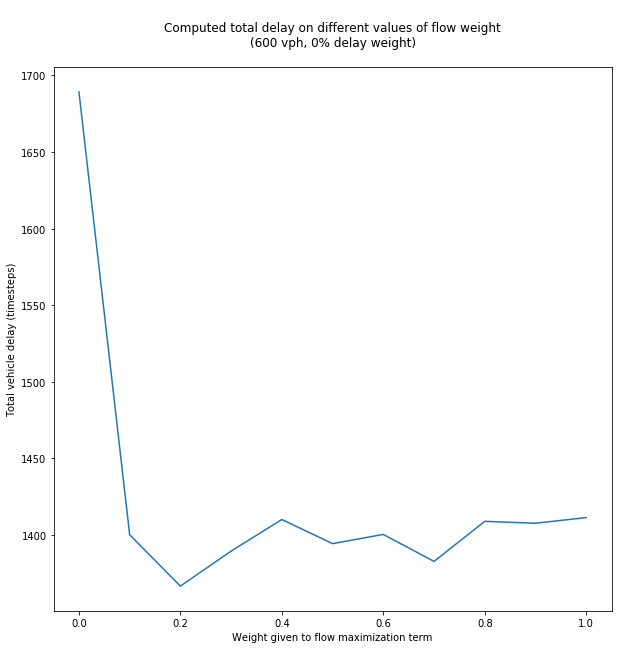

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.plot(np.arange(0,1.05,0.1), [x[0] for x in obj_value_list])
ax.set_title('''
Computed total delay on different values of flow weight
(600 vph, 0% delay weight)
''')
ax.set_ylabel("Total vehicle delay (timesteps)")
ax.set_xlabel("Weight given to flow maximization term")
fig.savefig("graphs/delay.png")

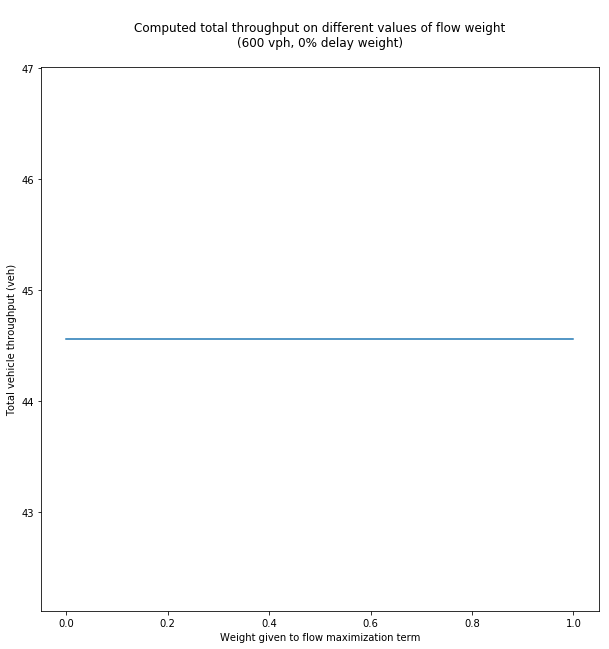

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.plot(np.arange(0,1.05,0.1), [x[1] for x in obj_value_list])
ax.set_title('''
Computed total throughput on different values of flow weight
(600 vph, 0% delay weight)
''')
ax.set_ylabel("Total vehicle throughput (veh)")
ax.set_xlabel("Weight given to flow maximization term")
fig.savefig("graphs/throughput.png")

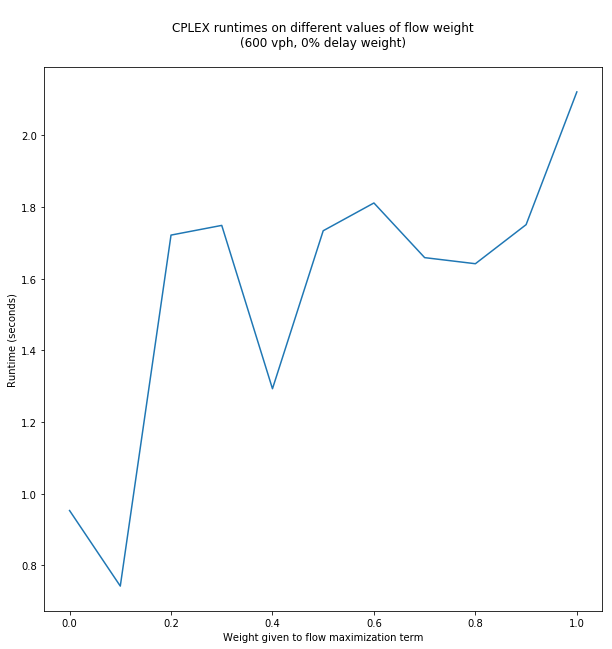

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.plot(np.arange(0,1.05,0.1), runtimes)
ax.set_title('''
CPLEX runtimes on different values of flow weight
(600 vph, 0% delay weight)
''')
ax.set_ylabel("Runtime (seconds)")
ax.set_xlabel("Weight given to flow maximization term")
fig.savefig("graphs/runtimes.png")

**VERDICT:** Inconclusive, but cursory examination of graphs reveal a flow weight of 0.6

**Notes:**
* For alpha = 1, objective function values dont vary with flow weight
* For alpha = 0, delay values vary between 1350 and 1450; throughput values don't
* Runtime graphs are erratic
* Flow diagrams are more or less erratic, some flow weights (e.g. 0.4) give more erratic flow diagrams than others

## 2. Checking the effect of traffic demand

### Alpha = 1, Flow weight = 0.6, Demand = [450, 900]

In [19]:
demands = [x for x in range(450, 901, 50)]
demands2 = [x for x in range(950, 1801, 50)]

#runtimes = []
#obj_value_list = []
alpha = 1
flow_weight = 0.6

for d in demands2:
    dfx, dfy, dfg, dfparams, obj_values, runtime = run_model(demand=d, alpha=alpha, use=True, flow_weight=flow_weight)
    runtimes.append(runtime)
    obj_value_list.append(obj_values)
    
    generate_graphs(dfx, dfy, dfg, dfparams.capacity[(3,0,1)], dfparams.max_flow[(3,0,1)], d, alpha, flow_weight, folder='demands/')
    print("\n~~~\nDone with {}!\n~~~\n".format(d))

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 1940 rows and 292 columns.
MIP Presolve modified 752 coefficients.
Aggregator did 128 substitutions.
Reduced MIP has 3482 rows, 1860 columns, and 12232 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.67 ticks)
Found incumbent of value 3586.978307 after 0.04 sec. (26.16 ticks)
Probing fixed 0 vars, tightened 142 bounds.
Probing time = 0.00 sec. (0.61 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2790 rows, 1668 columns, and 10524 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.55 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 2790 rows, 1668 columns, and 10524 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.


   1468   520      476.2326    45      478.2292      461.0498   101857    3.59%
*  1501+  490                          477.7920      461.5256             3.40%
*  1607+  523                          477.7920      462.4485             3.21%
   1831   560      472.9749    71      477.7920      464.4255   117779    2.80%
   2239   657      474.5247    32      477.7920      466.7770   144093    2.31%
*  2362   684      integral     0      475.5036      467.7233   150103    1.64%
   2731   380        cutoff            475.5036      470.3563   166787    1.08%
   3209   162        cutoff            475.5036      472.7539   181591    0.58%

Cover cuts applied:  138
Implied bound cuts applied:  2
Flow cuts applied:  25
Mixed integer rounding cuts applied:  23
Zero-half cuts applied:  6
Lift and project cuts applied:  4
Gomory fractional cuts applied:  18

Root node processing (before b&c):
  Real time             =    1.15 sec. (839.63 ticks)
Parallel b&c, 8 threads:
  Real time             =  

      0     0      686.2478   126      803.4383      Cuts: 22      743   14.59%
*     0+    0                          792.5426      686.2478            13.41%
      0     0      686.2478   119      792.5426   ZeroHalf: 2      749   13.41%
      0     0      686.2478   125      792.5426      Cuts: 35      790   13.41%
*     0+    0                          754.4472      686.2478             9.04%
      0     2      686.2478   120      754.4472      692.4925      790    8.21%
Elapsed time = 1.22 sec. (938.65 ticks, tree = 0.01 MB, solutions = 6)
    238   110      753.5922    73      754.4472      693.7289    16406    8.05%
    540   176      740.9247    75      754.4472      705.3572    33720    6.51%
*   606   203      integral     0      754.2567      705.3572    36964    6.48%
*   733   280      integral     0      752.0011      711.9212    45388    5.33%
*   743   311      integral     0      751.7636      711.9212    50159    5.30%
*   752   310      integral     0      751.5262  

*     0+    0                         4503.4939    -6131.3632           236.15%
      0     0      946.6915   116     4503.4939      946.6915       26   78.98%
*     0+    0                         1160.3120      946.6915            18.41%
      0     0      955.5222   137     1160.3120      Cuts: 54      260   17.65%
      0     0      960.8585   114     1160.3120      Cuts: 60      440   17.19%
      0     0      961.5300   120     1160.3120      Cuts: 24      491   17.13%
      0     0      961.5300   120     1160.3120    MIRcuts: 5      495   17.13%
*     0+    0                         1131.5134      961.5300            15.02%
*     0+    0                         1091.7298      961.5300            11.93%
*     0+    0                         1074.1740      961.5300            10.49%
*     0+    0                         1037.2255      961.5300             7.30%
      0     2      961.5300   120     1037.2255      962.0271      495    7.25%
Elapsed time = 0.98 sec. (748.50 ticks, 

Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.56 ticks)
Probing time = 0.01 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 2814 rows, 1680 columns, and 10540 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.26 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Clique table members: 120.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.18 sec. (193.43 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         4867.0009    -6109.8310           225.54%
      0     0     1265.4102    84     4867.0009     1265.4102       25   74.00%
*     0+    0                         1502.3398     1265.4102            15.77%
      0     0     126

Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2814 rows, 1680 columns, and 10540 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.56 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 2814 rows, 1680 columns, and 10540 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.26 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Clique table members: 120.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.21 sec. (207.00 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         5228.7562    -6088.4347           216.44%
      0    

  Sync time (average)   =    0.51 sec.
  Wait time (average)   =    0.01 sec.
                          ------------
Total (root+branch&cut) =    3.23 sec. (2215.42 ticks)
Done!
Time elapsed: 4.0106511116

~~~
Done with 1450!
~~~

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 1928 rows and 292 columns.
MIP Presolve modified 752 coefficients.
Aggregator did 116 substitutions.
Reduced MIP has 3506 rows, 1872 columns, and 12248 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.64 ticks)
Found incumbent of value 5588.772250 after 0.03 sec. (26.41 ticks)
Probing fixed 0 vars, tightened 140 bounds.
Probing time = 0.00 sec. (0.61 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2814 rows, 1680 columns, and 10540 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.


*   610+  204                         2234.0956     2202.7978             1.40%
*   624+  204                         2233.6573     2203.1061             1.37%
*   645+  217                         2228.1569     2203.1061             1.12%
*   673+  227                         2226.7577     2203.1061             1.06%
    734   197     2222.4902    74     2226.7577     2203.1061    34836    1.06%
*  1097+  287                         2224.8944     2213.0414             0.53%
   1097   304     2226.0136    35     2224.8944     2213.0414    49487    0.53%
*  1391+  294                         2224.7203     2213.2694             0.51%
   1408   313        cutoff           2224.7203     2213.2694    58455    0.51%
*  1416+  282                         2224.7203     2213.2694             0.51%
*  1424   309      integral     0     2224.6577     2213.2694    58076    0.51%
*  1429   298      integral     0     2224.4209     2213.2694    61183    0.50%
   1816   214        cutoff           22

      0     0     2540.6171   118     2629.7498   Flowcuts: 1      426    3.31%
      0     0     2540.6214   118     2629.7498      Cuts: 19      440    3.31%
*     0+    0                         2610.6466     2542.6835             2.60%
*     0+    0                         2605.6759     2546.6770             2.26%
      0     2     2540.6214   114     2605.6759     2546.6770      440    2.26%
Elapsed time = 1.08 sec. (743.87 ticks, tree = 0.01 MB, solutions = 7)
*   192+   64                         2593.4404     2555.9691             1.44%
    220    87     2571.0298    86     2593.4404     2555.9691    14564    1.44%
*   304+   74                         2585.8059     2564.3364             0.83%
    538   130        cutoff           2585.8059     2568.4930    35063    0.67%
    989   216     2584.8097    30     2585.8059     2576.7943    55086    0.35%
*  1112   240      integral     0     2585.7433     2578.4059    60340    0.28%
*  1304   262      integral     0     2585.5693  

      0     0     2895.8161   125     3190.8861      Cuts: 27      109    9.19%
*     0+    0                         2961.8771     2897.7050             2.17%
      0     0     2897.4248    95     2961.8771      Cuts: 24      234    2.04%
      0     0     2904.6246   113     2961.8771      Cuts: 23      370    1.93%
      0     0     2904.6277   113     2961.8771      Cuts: 21      384    1.93%
      0     2     2904.6277   105     2961.8771     2905.6235      384    1.90%
Elapsed time = 0.97 sec. (730.62 ticks, tree = 0.01 MB, solutions = 4)
*   100+   67                         2958.4649     2912.7538             1.55%
*   106+   46                         2952.9945     2912.7538             1.36%
    264   127     2938.7118    96     2952.9945     2915.3601    12308    1.27%
*   275+  121                         2946.5107     2915.3601             1.06%
    628   176     2942.6415    57     2946.5107     2933.6511    22933    0.44%
*   757+  229                         2946.0378  

In [22]:
demands = demands+demands2
demands

[450,
 500,
 550,
 600,
 650,
 700,
 750,
 800,
 850,
 900,
 950,
 1000,
 1050,
 1100,
 1150,
 1200,
 1250,
 1300,
 1350,
 1400,
 1450,
 1500,
 1550,
 1600,
 1650,
 1700,
 1750,
 1800]

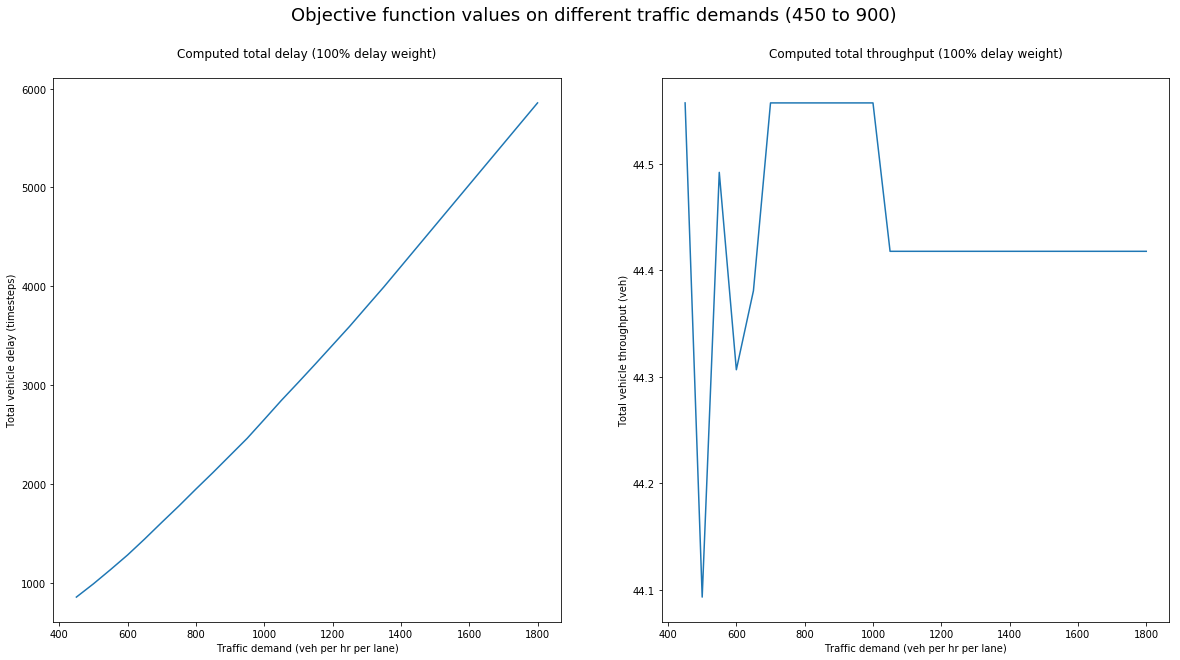

In [23]:
fig, axs = plt.subplots(1,2,figsize=(20,10))

fig.suptitle("Objective function values on different traffic demands (450 to 900)", fontsize=18)

axs[0].plot(demands, [x[0] for x in obj_value_list])
axs[0].set_title('''
Computed total delay (100% delay weight)
''')
axs[0].set_ylabel("Total vehicle delay (timesteps)")
axs[0].set_xlabel("Traffic demand (veh per hr per lane)")

axs[1].plot(demands, [x[1] for x in obj_value_list])
axs[1].set_title('''
Computed total throughput (100% delay weight)
''')
axs[1].set_ylabel("Total vehicle throughput (veh)")
axs[1].set_xlabel("Traffic demand (veh per hr per lane)")

fig.savefig("graphs/obj.png")

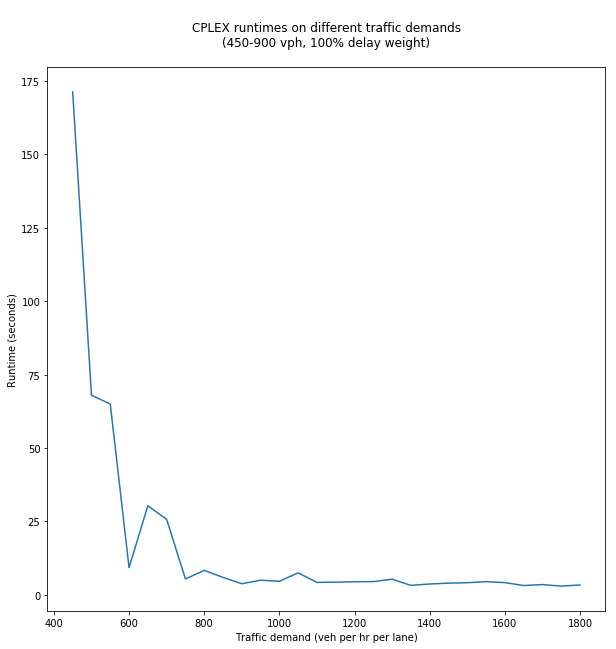

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.plot(demands, runtimes)
ax.set_title('''
CPLEX runtimes on different traffic demands
(450-900 vph, 100% delay weight)
''')
ax.set_ylabel("Runtime (seconds)")
ax.set_xlabel("Traffic demand (veh per hr per lane)")
fig.savefig("graphs/runtimes.png")

In [30]:
df = pd.DataFrame(data={
    'demand': demands,
    'runtime': runtimes,
    'delay': [x[0] for x in obj_value_list],
    'throughput': [x[1] for x in obj_value_list],
    'alpha': [1 for x in demands],
    'flow_weight': [0.6 for x in demands]
})

df.to_pickle("tmp.pkl")